In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from kohonen import Kohonen
from oja import Oja
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(10, 10))
plt.rc('figure', facecolor=(1,1,1,1))

In [2]:
 #loading data
dataset = pd.read_csv('europe.csv')

#le sacamos el nombre de los paises
countries = dataset.iloc[:,0]
variable_names = dataset.iloc[:,1:].columns
variables = dataset.iloc[:, 1:].values



standarized = (variables - variables.mean(axis=0))/variables.std(axis=0)

In [7]:
initial_k = 3
network = Kohonen(standarized, seed=0, k = initial_k, initial_n=0.5, initial_radius=2)

In [8]:
def calculate_u_matrix(network):
    n_distances = np.zeros((network.k, network.k))
    
    for i in range(network.k):
        for j in range(network.k):
            row = list(filter(lambda x: x >= 0 and x < network.k, [i-1,i+1]))
            col = list(filter(lambda x: x >= 0 and x < network.k, [j-1,j+1]))
            neigborhood = np.linalg.norm([network.weights[i,j] for j in col] + [network.weights[i,j] for i in row] - network.weights[i,j], axis=1) 
            distance =np.sum(neigborhood)/len(neigborhood)
            n_distances[j,i] += distance
    return n_distances


In [9]:
def plot_u_matrix(network, dataset):
    n_distances = calculate_u_matrix(network)
    
    for i in range(network.k):
        for j in range(network.k):
            plt.text(i+0.5, j+0.5, round(n_distances[j,i],3), ha='center', va='center',  bbox = dict(facecolor = 'white', alpha = 0.5))

    plt.pcolormesh(n_distances, cmap="Greys")
    plt.colorbar()


In [10]:
def plot_countries(network, countries_name, dataset, arrows = False):

    if arrows:
        for j in range(network.k):
            for i in range(network.k-1):
                # distance 0 --> width 20
                # distance 2 --> width 0
                width = lambda x: 20 - 10*x if x<2 else 0
                distance = np.linalg.norm(network.weights[i,j] - network.weights[i+1,j])

                line = plt.Line2D([i+0.5,i+0.5+1],[j+0.5,j+0.5], color='red', linewidth=width(distance))
                plt.gca().add_line(line)
                distance = np.linalg.norm(network.weights[j,i] - network.weights[j,i+1])

                line = plt.Line2D([j+0.5,j+0.5],[i+0.5,i+0.5 + 1], color='red', linewidth=width(distance))
                plt.gca().add_line(line)


    strings = [["    \n" for i in range(network.k)] for i in range(network.k)]
    for country, row in zip(countries_name, dataset):
        (i,j), distances  = network.predict(row)
        strings[i][j] += country + "\n"

    for i in range(network.k):
        for j in range(network.k):
            plt.text(j+0.5, i+0.5, strings[i][j], ha='center', va='center',  bbox = dict(facecolor = 'white', alpha = 1))
    
    plt.ylim(0, network.k)
    plt.xlim(0, network.k)
    plt.xticks(np.arange(network.k))
    plt.yticks(np.arange(network.k))
    plt.grid()


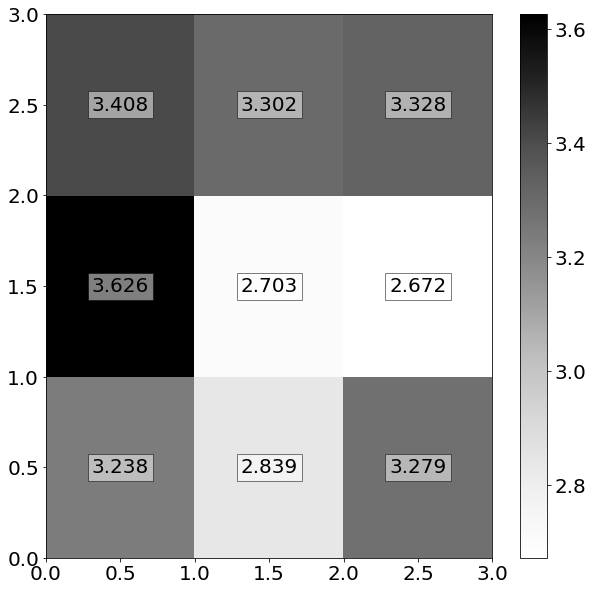

In [11]:
plt.figure("U matrix before training")
plot_u_matrix(network, standarized)

In [12]:
u_matrix = []
def callback(network):
    #u_matrix.append(calculate_u_matrix(network))
    u_matrix.append(calculate_u_matrix(network).flatten().mean())

In [13]:
network.train(epochs=3500, callback=callback)

KeyboardInterrupt: 

In [ ]:
plt.plot(u_matrix)
plt.show()

In [ ]:
plt.figure("U matrix after training")
plot_u_matrix(network, standarized)

In [ ]:
plt.figure("Countries cluster", figsize=(20,20))
plot_countries(network, countries, standarized, arrows=True)

In [ ]:
for idx, var in enumerate(variable_names):
    plt.figure(var, figsize=(20,20))
    plt.title(var)
    V = network.weights[:,:,idx]
    V = np.flip(V, axis=0)
    plt.imshow(V, cmap="jet", extent=[0, network.k, 0, network.k], interpolation='sinc')
    X = np.arange(network.k)

    #plt.pcolormesh(V, cmap="jet")
    #plot_countries(network, countries, standarized, arrows=False)
    plt.colorbar()
